In [1]:
import tensorflow as tf
import tensorflow_hub  as hub
import tensorflow_text as tex

In [2]:
import pandas as pd

df = pd.read_csv('spam.csv')
df.head(3)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [6]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [7]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])

In [8]:
df_balanced = pd.concat([df_spam ,df_ham_downsampled])

In [9]:
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [11]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
4605,ham,THANX 4 PUTTIN DA FONE DOWN ON ME!!,0
797,spam,"Orange customer, you may now claim your FREE C...",1
4036,spam,YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...,1
1734,spam,"Hi, this is Mandy Sullivan calling from HOTMIX...",1
3690,ham,You still coming tonight?,0


In [13]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(df_balanced['Message'] , df_balanced['spam'] , stratify = df_balanced['spam'])

In [14]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [17]:
def get_sentences_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']
get_sentences_embedding([
    'Hurry up! 500₺ discount',
    'Are you up for a volleybal game for tomorrow'
])



<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7827099 , -0.3641476 , -0.701058  , ..., -0.35054457,
        -0.6492707 ,  0.9127707 ],
       [-0.89097846, -0.401741  , -0.44692948, ..., -0.25311223,
        -0.6334101 ,  0.92146254]], dtype=float32)>

In [19]:
e = get_sentences_embedding([
    'banana',
    'apple',
    'grapes',
    'jeff bezos',
    'lionel messi',
    'Bill Gates'
])


In [20]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76069176, -0.14219394,  0.4960459 , ...,  0.42165306,
        -0.5322142 ,  0.8031218 ],
       [-0.8196456 , -0.296096  ,  0.20951842, ...,  0.25593403,
        -0.5874298 ,  0.8434555 ],
       [-0.86023223, -0.21242936,  0.4915693 , ...,  0.3979806 ,
        -0.6050628 ,  0.84471637],
       [-0.82533467, -0.35550585, -0.590697  , ..., -0.01613702,
        -0.6141757 ,  0.87230295],
       [-0.94586444, -0.4398569 , -0.69371873, ..., -0.6234146 ,
        -0.62076   ,  0.9259535 ],
       [-0.7854437 , -0.2994969 ,  0.41027388, ...,  0.5222541 ,
        -0.4957355 ,  0.815075  ]], dtype=float32)>

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[5]] , [e[0]])


array([[0.95718396]], dtype=float32)

In [28]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string , name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1 , name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name = 'output')(l)

model = tf.keras.Model(inputs=[text_input] , outputs=[l])

In [29]:
model.summary(
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [31]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precission'),
]

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics = METRICS)


In [32]:
model.fit(x_train , y_train , epochs=10)

Epoch 1/10
35/35 [==============================] - 92s 3s/step - loss: 0.6556 - accuracy: 0.6009 - recall: 0.5768 - precission: 0.6060
Epoch 2/10
35/35 [==============================] - 93s 3s/step - loss: 0.5047 - accuracy: 0.8188 - recall: 0.8214 - precission: 0.8171
Epoch 3/10
35/35 [==============================] - 97s 3s/step - loss: 0.4289 - accuracy: 0.8625 - recall: 0.8571 - precission: 0.8664
Epoch 4/10
35/35 [==============================] - 100s 3s/step - loss: 0.3895 - accuracy: 0.8777 - recall: 0.8964 - precission: 0.8640
Epoch 5/10
35/35 [==============================] - 97s 3s/step - loss: 0.3503 - accuracy: 0.8929 - recall: 0.9143 - precission: 0.8767
Epoch 6/10
35/35 [==============================] - 97s 3s/step - loss: 0.3340 - accuracy: 0.8848 - recall: 0.9143 - precission: 0.8634
Epoch 7/10
35/35 [==============================] - 97s 3s/step - loss: 0.3126 - accuracy: 0.9009 - recall: 0.9036 - precission: 0.8988
Epoch 8/10
35/35 [=============================

In [34]:
model.evaluate(x_test , y_test)

12/12 [==============================] - 27s 2s/step - loss: 0.2772 - accuracy: 0.8984 - recall: 0.8984 - precission: 0.8984


[0.27720269560813904,
 0.8983957171440125,
 0.8983957171440125,
 0.8983957171440125]

In [35]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 28s 2s/step


In [36]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5 , 1 , 0)
y_predicted


array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

In [37]:
from sklearn.metrics import confusion_matrix  , classification_report

cm = confusion_matrix(y_test , y_predicted)
cm

array([[168,  19],
       [ 19, 168]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

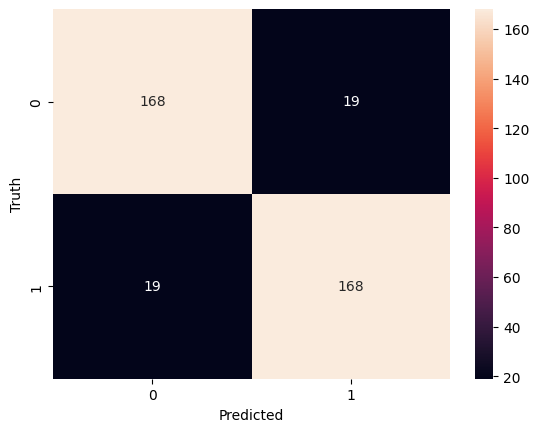

In [42]:
from matplotlib import pyplot as pyp
import seaborn as sn

sn.heatmap(cm , annot = True , fmt='d' )
pyp.xlabel('Predicted')
pyp.ylabel('Truth')


In [44]:
reviews = [
    "500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY £1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18",
    "Sorry, I'll call later",
    "Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES",
    "Why don't you wait 'til at least wednesday to see if you get your .",
    "his is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
]

model.predict(reviews)

1/1 [==============================] - 1s 866ms/step


array([[0.97890127],
       [0.07556549],
       [0.6279521 ],
       [0.09438836],
       [0.78501594]], dtype=float32)

In [48]:
def spam_predict(text):
    predict = model.predict(text)
    if predict >=0.5:
        print("This Massage seems Spam!!!!")
        print(predict)
    else : 
        print("This Massage seems Normal")
        print(predict)

In [49]:
spam_predict(["Dear Arda, I wanted to follow up on my previous email to make sure you don't miss out on a great opportunity to connect during your trial. "])

1/1 [==============================] - 0s 151ms/step
This Massage seems Spam!!!!
[[0.5794202]]
